In [23]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import datetime
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors
import seaborn as sns
import os
import shutil
import json
import pickle
import itertools
from scipy.signal import savgol_filter

np.random.seed(42)

from formats import experiment_pb2
from formats import  quantification_pb2

from skimage import io
import pandas as pd
import utils


from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, ChainDataset

import umap

import os
import pyro
import pyro.distributions as dist
import pyro.poutine
from pyro.infer import MCMC, NUTS
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide.guides import AutoDiagonalNormal
import pyro.distributions.constraints as constraints
from tqdm import trange

import utils

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('default')

In [3]:
local_radius_px = 5

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# device =  "cpu" 


In [5]:
import data
from data import PixlMap

 ... Aggregating Quants ...

In [6]:
dataset = PixlMap('089063943')
# dataset = PixlMap('093258245')

data_loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=256)


In [7]:
def crop_img(img):
    try:
        indicies = np.where(img)
        non_zero_rows = indicies[0]
        non_zero_cols = indicies[1]
        row1 = min(non_zero_rows)
        row2 = max(non_zero_rows)
        col1 = min(non_zero_cols)
        col2 = max(non_zero_cols)
        crop_img = img[row1:row2, col1:col2]
        return crop_img, row1, row2, col1, col2
    except:
        return img, 0, img.shape[0],0,img.shape[1]

In [8]:
def eval_recon(x_hat,q_hat, x, q):
    x_flat = x.reshape(-1,x.shape[-1])
    x_hat_flat = x_hat.reshape(-1,x.shape[-1])
    x_mean = np.mean(x_flat,0)
    x_ssr = np.sum(np.power(x_flat - x_hat_flat,2))
    x_sst = np.sum(np.power((x_flat - x_mean),2))
    x_r2 = 1 - x_ssr/x_sst

    q_mean = np.mean(q,0)
    q_ssr = np.sum(np.power((q - q_hat),2))
    q_sst = np.sum(np.power((q - q_mean),2))
    q_r2 = 1 - q_ssr/q_sst

    return x_r2.item(),q_r2.item()

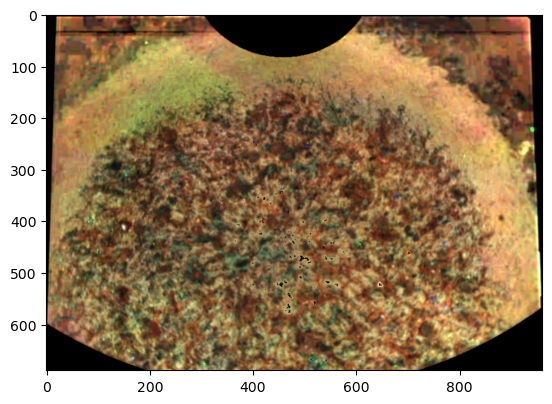

In [9]:
plt.imshow(crop_img(dataset.rgbu_data.astype(int)[:,:,:3])[0])


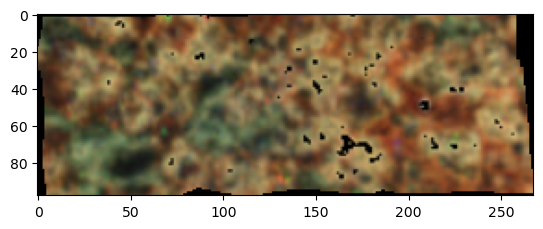

In [10]:
plt.imshow(crop_img(dataset.convert_batch_latents_to_image(dataset.convert_to_model_batch()[0]))[0][:,:,:3].astype(int))


In [11]:
def get_batch_indicies_from_img(img_i,img_j):
    pmc_map = dataset.pmc_map
    batch_mask = np.zeros((len(dataset),dataset.local_radius*2,dataset.local_radius*2),bool)
    for i in range(len(dataset.pmc)):
        pmc = dataset.pmc[i]
        pmc_i_diff = int(pmc_map[pmc]['i']-img_i)
        pmc_j_diff = int(pmc_map[pmc]['j']-img_j)
        pixel_in_pmc_range = (-dataset.local_radius <= pmc_i_diff < dataset.local_radius) and (-dataset.local_radius <= pmc_j_diff < dataset.local_radius)
        if pixel_in_pmc_range:
            batch_mask[i,int(pmc_j_diff)+dataset.local_radius,int(pmc_i_diff)+dataset.local_radius] = True
    batch_mask = batch_mask.reshape((len(dataset),-1))
    return batch_mask

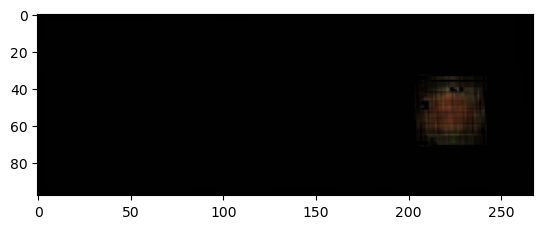

In [12]:
center = (555,460)
radius = 10
mask = get_batch_indicies_from_img(center[0],center[1])
for i in range(-radius,radius):
    for j in range(-radius,radius):
        mask = mask | get_batch_indicies_from_img(center[0]+i,center[1]+j)

test = np.zeros_like(dataset.convert_to_model_batch()[0])+1
test[mask] = dataset.convert_to_model_batch()[0][mask]
img = dataset.convert_batch_latents_to_image(test)
img = crop_img(img)[0]

plt.imshow(img[:,:,:3].astype(int))
# img.shape
# mask

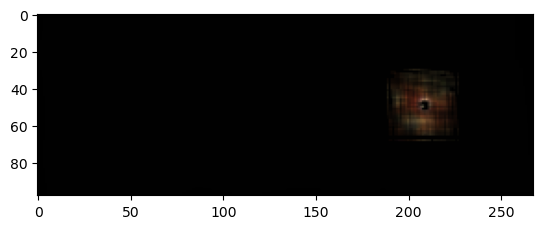

In [13]:
center = (540,457)
radius = 10
mask = get_batch_indicies_from_img(center[0],center[1])
for i in range(-radius,radius):
    for j in range(-radius,radius):
        mask = mask | get_batch_indicies_from_img(center[0]+i,center[1]+j)

test = np.zeros_like(dataset.convert_to_model_batch()[0])+1
test[mask] = dataset.convert_to_model_batch()[0][mask]
img = dataset.convert_batch_latents_to_image(test)
img = crop_img(img)[0]

plt.imshow(img[:,:,:3].astype(int))

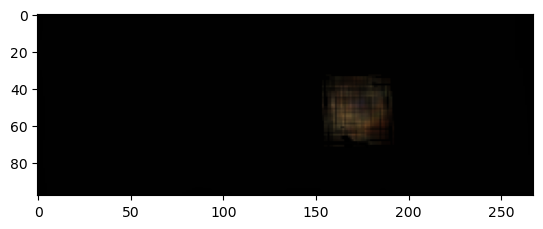

In [14]:
center = (505,460)
radius = 10
mask = get_batch_indicies_from_img(center[0],center[1])
for i in range(-radius,radius):
    for j in range(-radius,radius):
        mask = mask | get_batch_indicies_from_img(center[0]+i,center[1]+j)

test = np.zeros_like(dataset.convert_to_model_batch()[0])+1
test[mask] = dataset.convert_to_model_batch()[0][mask]
img = dataset.convert_batch_latents_to_image(test)
img = crop_img(img)[0]

plt.imshow(img[:,:,:3].astype(int))

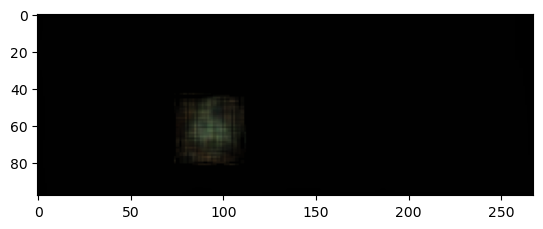

In [15]:
center = (425,470)
radius = 10
mask = get_batch_indicies_from_img(center[0],center[1])
for i in range(-radius,radius):
    for j in range(-radius,radius):
        mask = mask | get_batch_indicies_from_img(center[0]+i,center[1]+j)

test = np.zeros_like(dataset.convert_to_model_batch()[0])+1
test[mask] = dataset.convert_to_model_batch()[0][mask]
img = dataset.convert_batch_latents_to_image(test)
img = crop_img(img)[0]

plt.imshow(img[:,:,:3].astype(int))

In [16]:
import models
reload(models)
from models import FusionModel, NaiveFusionModel, SeparableVAE, JointVAE

In [17]:
def vis_model_response(model_path,latent_centers,radius,existing_ax=None,cmap=None,alpha=1.0,selection_threshold=None):
    if '.pt' in model_path:
        model = torch.load(model_path).eval().to(device)    

        x , q = [], []
        c, z = [], []
        x_hat, q_hat = [], []
        for batch_x,batch_q in data_loader:
            batch_x = batch_x.to(device)
            batch_q = batch_q.to(device)
            batch_c, batch_z = model.encode(batch_x,batch_q)
            batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
            x.append(batch_x.detach().cpu())
            q.append(batch_q.detach().cpu())
            z.append(batch_z.detach().cpu())
            x_hat.append(batch_x_hat.detach().cpu())
            q_hat.append(batch_q_hat.detach().cpu())

        x = torch.cat(x,dim=0).detach().cpu().numpy()
        q = torch.cat(q,dim=0).detach().cpu().numpy()
        z = torch.cat(z,dim=0).detach().cpu().numpy()
        x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
        q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()

        
    elif 'umap' in model_path:
        x , q = [], []
        for batch_x,batch_q in data_loader:
            batch_x = batch_x.to(device)
            x.append(batch_x.detach().cpu())

        x = torch.cat(x,dim=0).detach().cpu().numpy()
        path = model_path
        with open(path, 'rb') as f:
            umap_values = pickle.load(f)
        z = umap_values['z']
        z = z.reshape((x.shape[0],x.shape[1],-1))
    else:
        raise NotImplementedException(f'Model Path \'{model_path}\' Not Valid')
    
    
    cropped_img, min_i, max_i, min_j, max_j = crop_img(dataset.convert_batch_latents_to_image(x).astype(int)[:,:,:3])

        
    response_selection = np.zeros((x.shape[0],x.shape[1],1))
    for latent_center in latent_centers:
        response_z = (np.sum(np.abs((z.reshape(-1,z.shape[-1]) - latent_center)),1)).reshape((-1,1))
        response_selection[(response_z < radius).reshape((z.shape[0],z.shape[1],))] = 1
    z_img = dataset.convert_batch_latents_to_image(response_selection)[min_i:max_i, min_j:max_j]
    if selection_threshold:
        z_img[z_img>selection_threshold] = 1
    if not existing_ax:
        fig, axs = plt.subplots(1,1,figsize=(10,5))
    else:
        axs= existing_ax
    im = axs.imshow(z_img,cmap=cmap,alpha=alpha)

    if not existing_ax:
        plt.show()

In [18]:
def vis_latent_scatter_with_selection(model_path,center=None,selection_radius=None,bins=250,lims=None,min_cluster_size=15,response_latent_radius=1,selection_threshold=None,individual_cluster_response=False,mixed_cluster_response=True):
    if '.pt' in model_path:
        model = torch.load(model_path).eval().to(device)    

        x , q = [], []
        c, z = [], []
        x_hat, q_hat = [], []
        for batch_x,batch_q in data_loader:
            batch_x = batch_x.to(device)
            batch_q = batch_q.to(device)
            batch_c, batch_z = model.encode(batch_x,batch_q)
            batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
            x.append(batch_x.detach().cpu())
            q.append(batch_q.detach().cpu())
            z.append(batch_z.detach().cpu())
            x_hat.append(batch_x_hat.detach().cpu())
            q_hat.append(batch_q_hat.detach().cpu())

        x = torch.cat(x,dim=0).detach().cpu().numpy()
        q = torch.cat(q,dim=0).detach().cpu().numpy()
        z = torch.cat(z,dim=0).detach().cpu().numpy()
        x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
        q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()

        z = z.reshape(-1,z.shape[-1])
        
    elif 'umap' in model_path:
        path = model_path
        with open(path, 'rb') as f:
            umap_values = pickle.load(f)
        z = umap_values['z']
        z = z.reshape(-1,z.shape[-1])
    else:
        raise NotImplementedException(f'Model Path \'{model_path}\' Not Valid')
    
    
    if center and radius:
        mask = get_batch_indicies_from_img(center[0],center[1])
        for i in range(-selection_radius,selection_radius):
            for j in range(-selection_radius,selection_radius):
                mask = mask | get_batch_indicies_from_img(center[0]+i,center[1]+j)
        masked_z = z[mask.reshape((-1,))]

    else:
        masked_z = z
    

    from sklearn.cluster import HDBSCAN


    
    np.random.seed(42)
    clustering = HDBSCAN(min_cluster_size=min_cluster_size,store_centers="medoid",cluster_selection_method="leaf")
    clustering.fit(masked_z)
    unique_clusters = np.unique(clustering.labels_[clustering.labels_ >= 0])

    print(f'Noise Cluster Ratio : {np.mean(clustering.labels_ < 0)}')
#     print(f'Medioids :\n{clustering.medoids_}')
    
    
    fig, axs = plt.subplots(1,3,figsize=(20,5),sharex=True,sharey=True)
    sns.histplot(x=masked_z[:,0],y=masked_z[:,1], bins=bins, cmap="viridis",ax=axs[1])
    sns.histplot(x=z[:,0],y=z[:,1], bins=bins, cmap="viridis",ax=axs[0])
    sns.scatterplot(x=masked_z[:,0][clustering.labels_ >= 0],y=masked_z[:,1][clustering.labels_ >= 0], hue=clustering.labels_[clustering.labels_ >= 0],palette='tab10',marker='.',ax=axs[2])
    for ax in axs:
        ax.set_rasterization_zorder(0)
    
    
    plt.show()
    
    if mixed_cluster_response:
        print(f'Mixed Cluster Response:')
        fig, axs = plt.subplots(1,1,figsize=(10,5))
        for cluster in tqdm(unique_clusters,leave=False):
            cluster_points =  masked_z[clustering.labels_ == cluster]                   
            vis_model_response(model_path,
                               cluster_points,
                               radius=response_latent_radius,
                               existing_ax=axs,
                               alpha=0.5,
                              cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [(0,0,0,0),plt.colormaps['tab10'](cluster)]))
        plt.show()
    
    if individual_cluster_response:
        for cluster in unique_clusters:
            print(f'Cluster {cluster} Response:')
            cluster_points =  masked_z[clustering.labels_ == cluster]                   
            vis_model_response(model_path,cluster_points,radius=response_latent_radius)

Noise Cluster Ratio : 0.6424986056887897


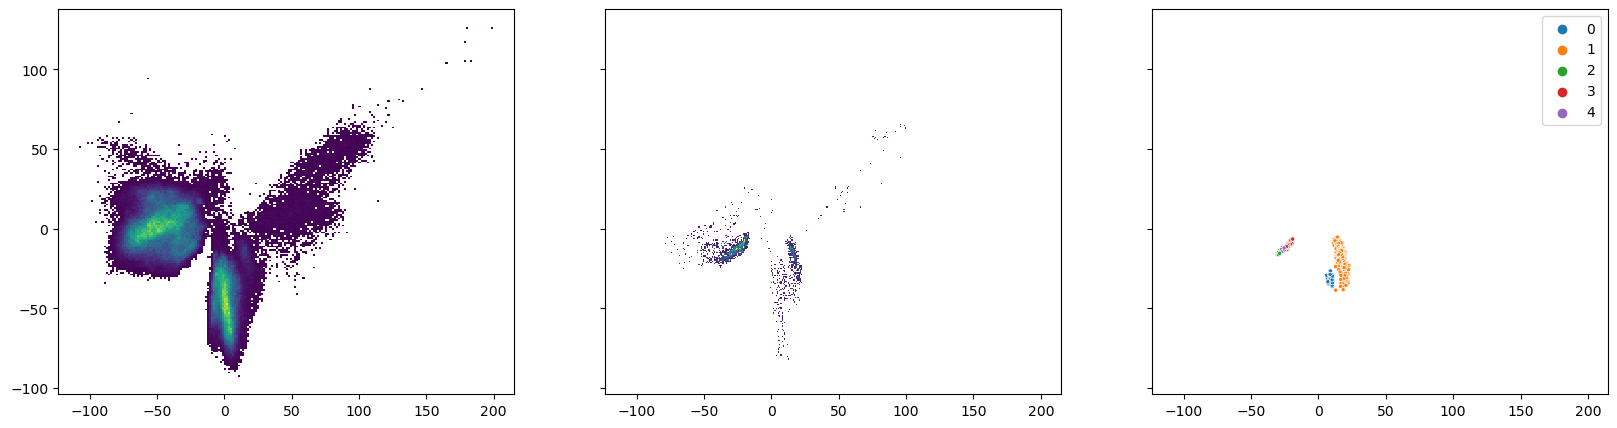

Mixed Cluster Response:


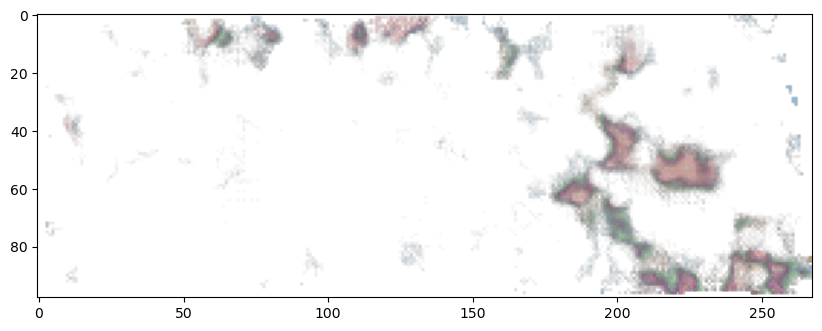

Cluster 0 Response:


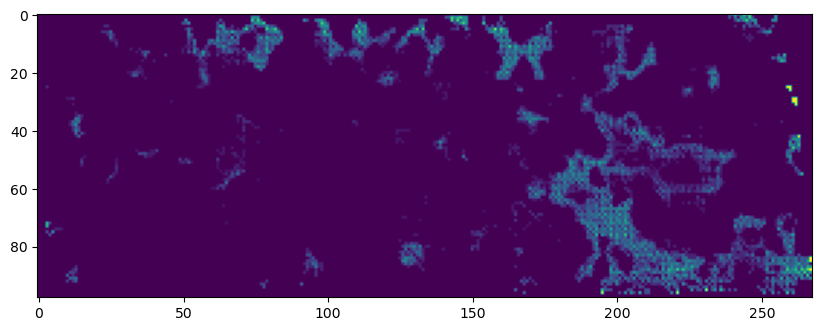

Cluster 1 Response:


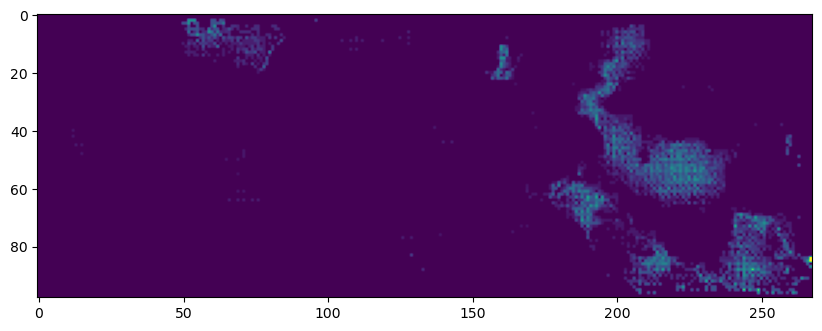

Cluster 2 Response:


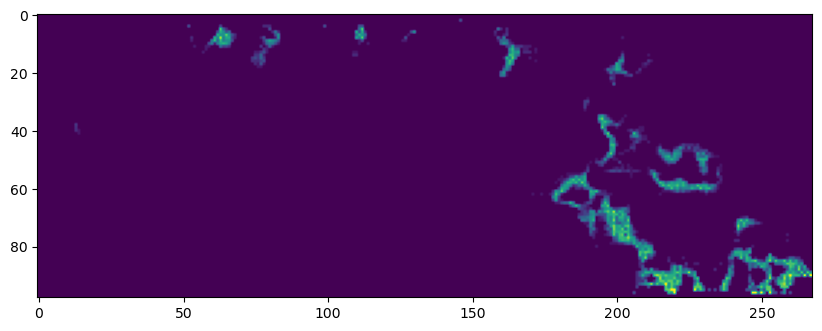

Cluster 3 Response:


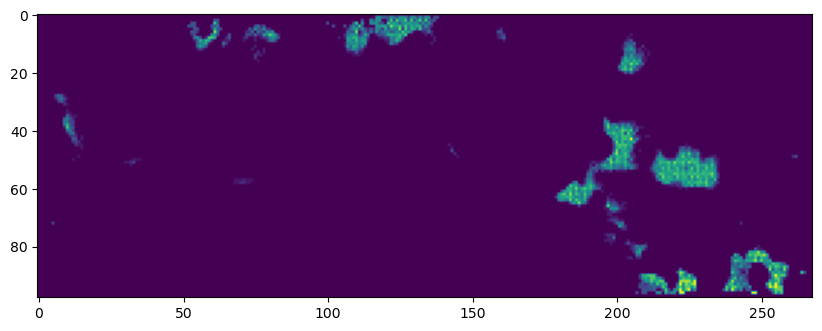

Cluster 4 Response:


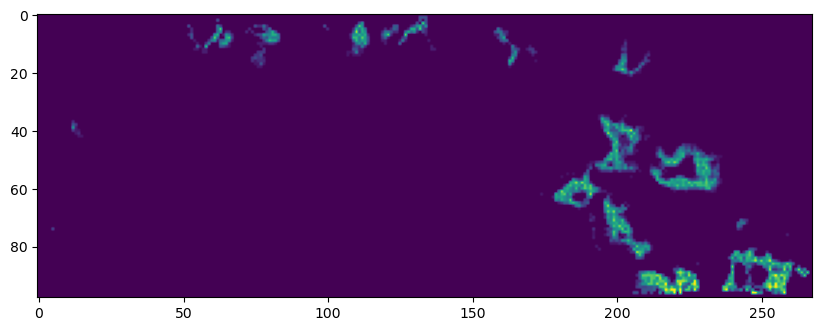

In [19]:
vis_latent_scatter_with_selection(f'models/FusionModel-z-2-c-1-h-256-d-4-r-5.pt',
    bins=200,
    min_cluster_size=25,
    center=(555,460),
    selection_radius=5,
    response_latent_radius=5,
    selection_threshold=None,                 
    mixed_cluster_response=True,
    individual_cluster_response=True                                                   
)

Noise Cluster Ratio : 0.6263245956497491


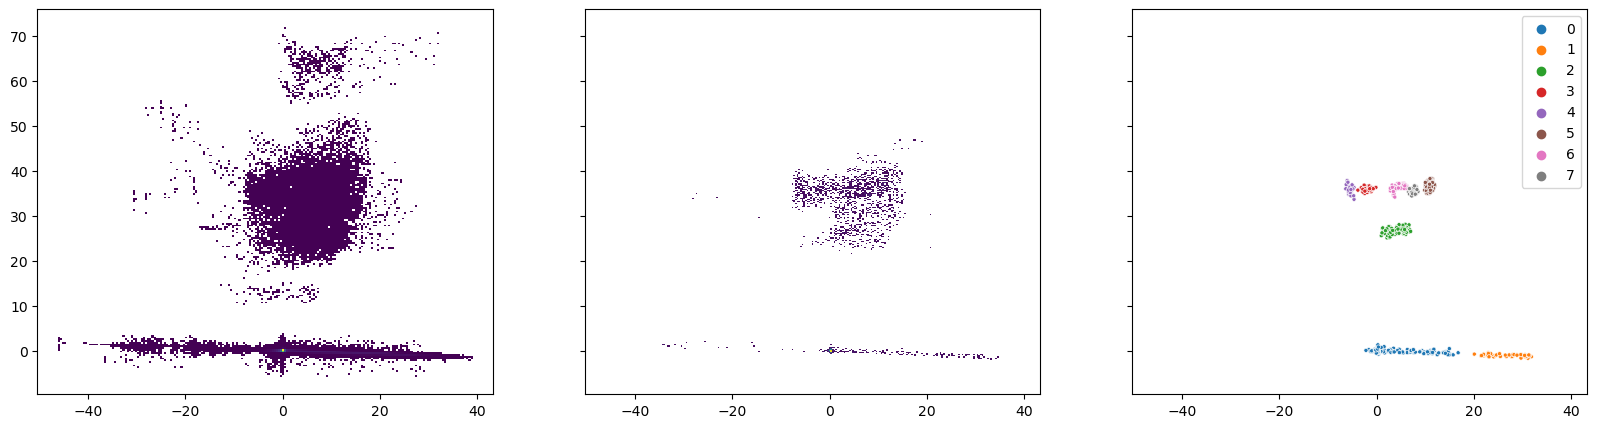

Mixed Cluster Response:


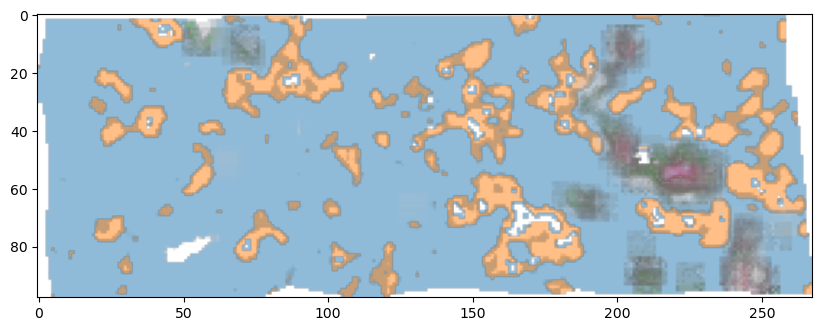

Cluster 0 Response:


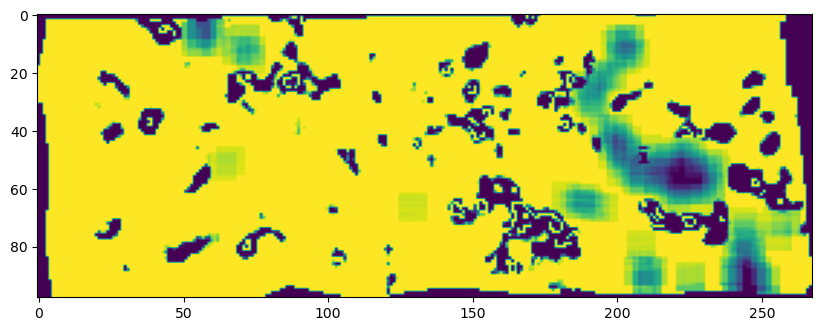

Cluster 1 Response:


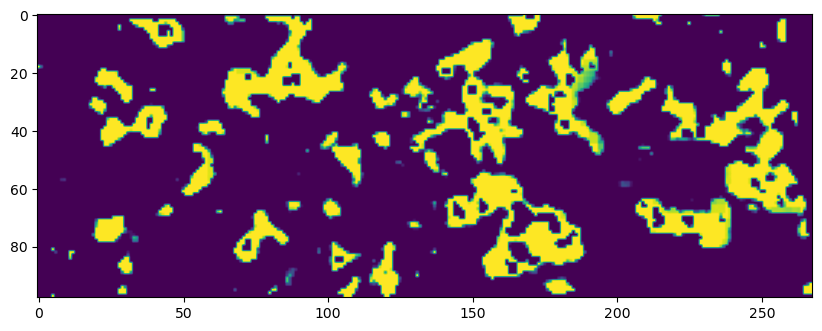

Cluster 2 Response:


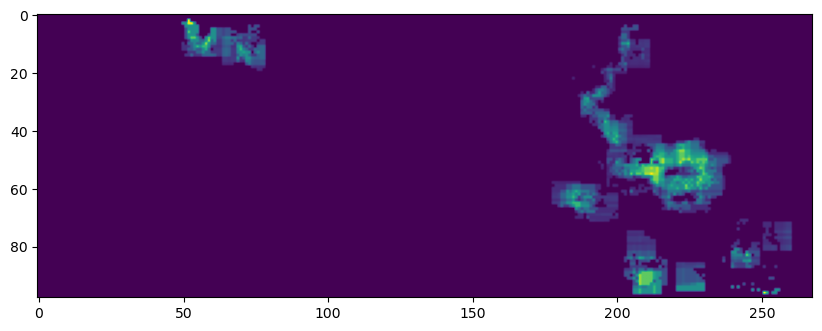

Cluster 3 Response:


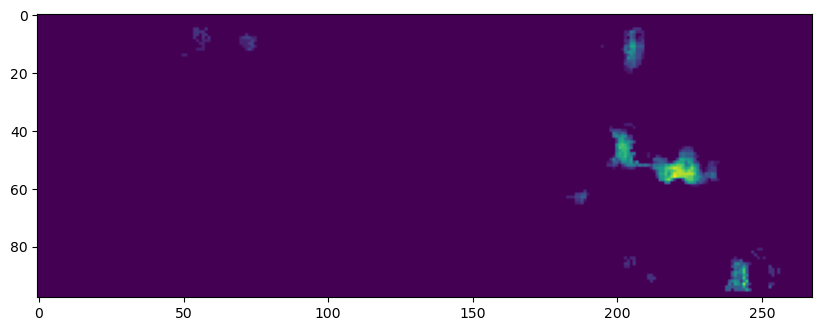

Cluster 4 Response:


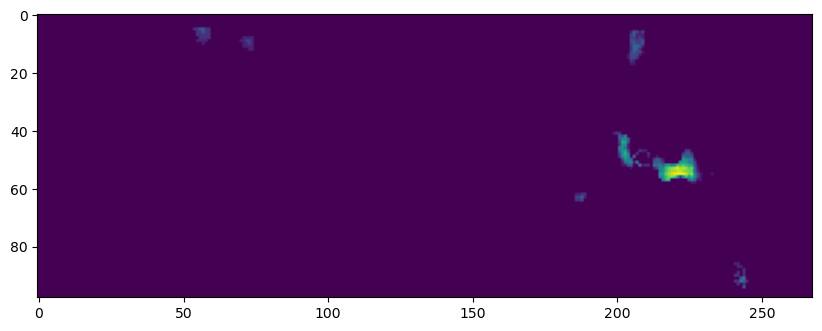

Cluster 5 Response:


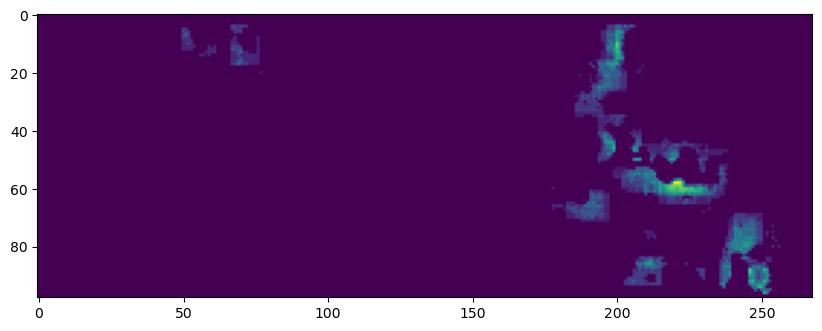

Cluster 6 Response:


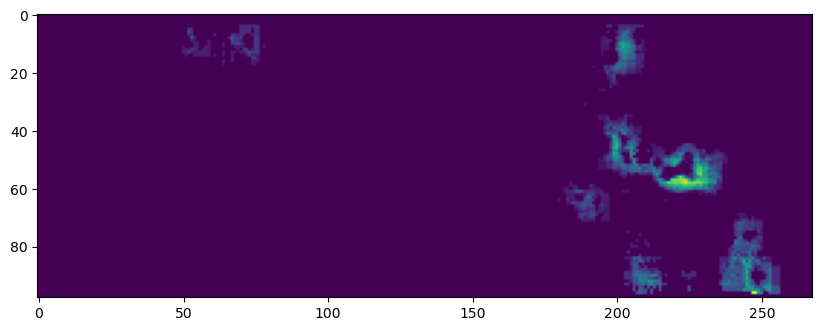

Cluster 7 Response:


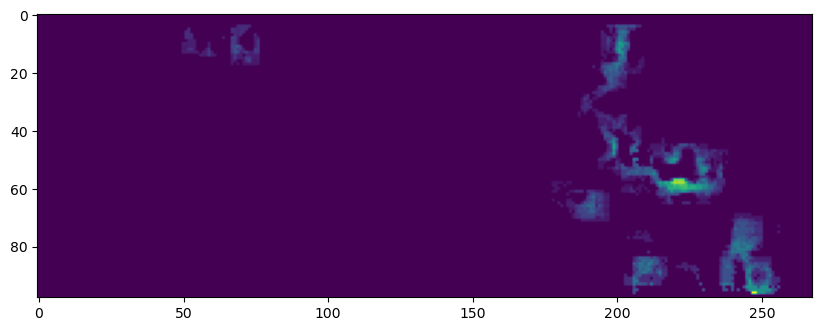

In [32]:
vis_latent_scatter_with_selection(f'models/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',
    bins=200,
    min_cluster_size=25,
    center=(555,460),
    selection_radius=5,
    response_latent_radius=5,
    selection_threshold=None,                 
    mixed_cluster_response=True,
    individual_cluster_response=True                                                   
)

Noise Cluster Ratio : 0.45008365867261574


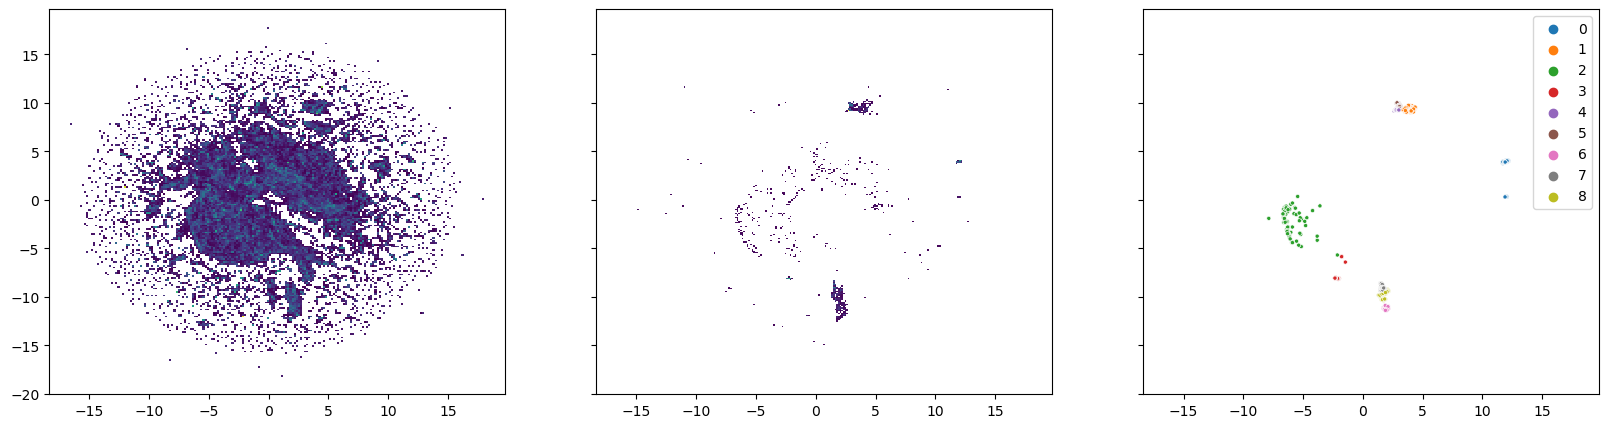

Mixed Cluster Response:


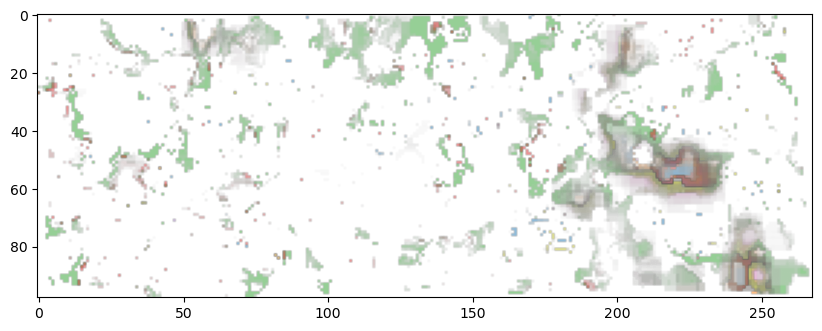

Cluster 0 Response:


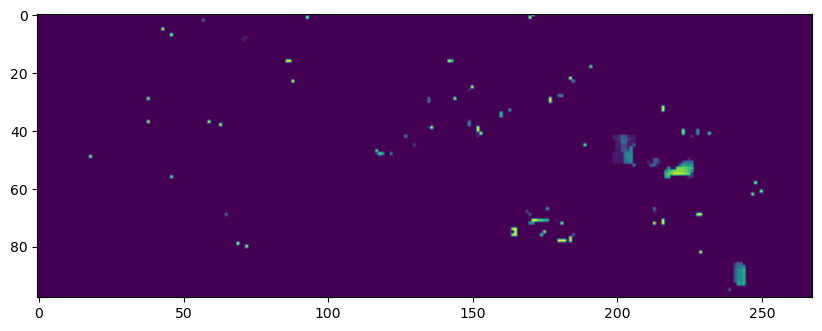

Cluster 1 Response:


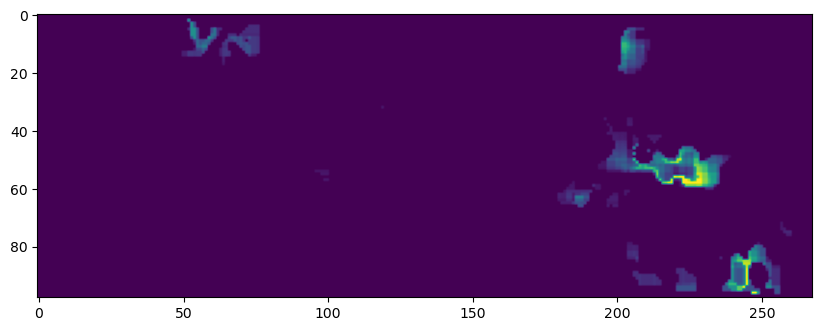

Cluster 2 Response:


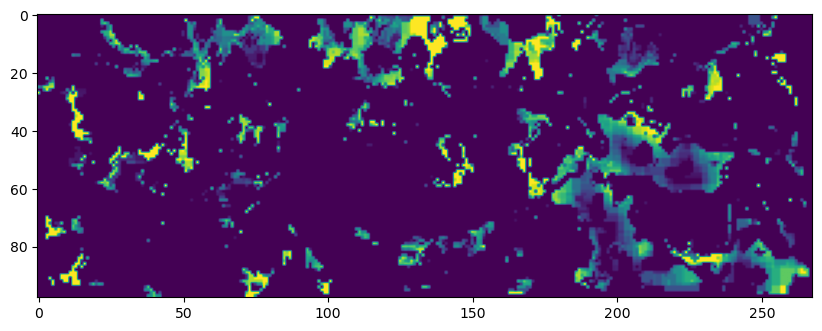

Cluster 3 Response:


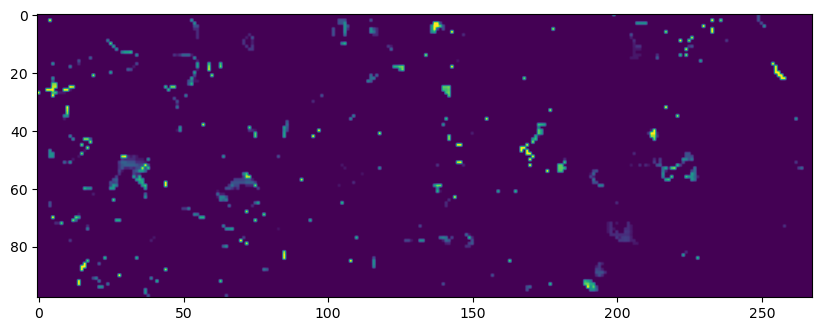

Cluster 4 Response:


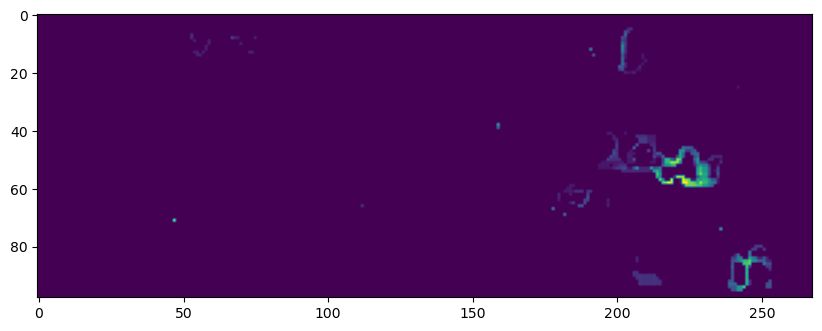

Cluster 5 Response:


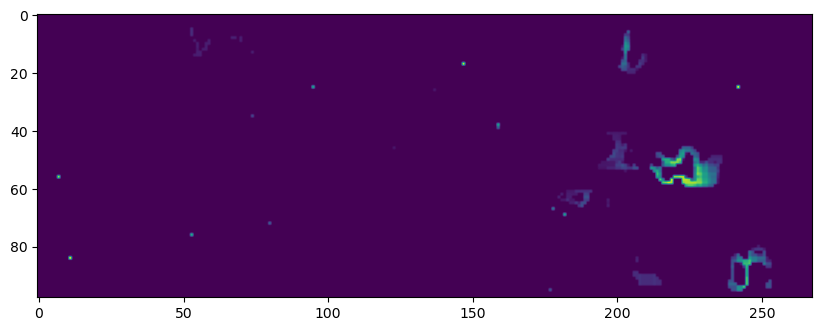

Cluster 6 Response:


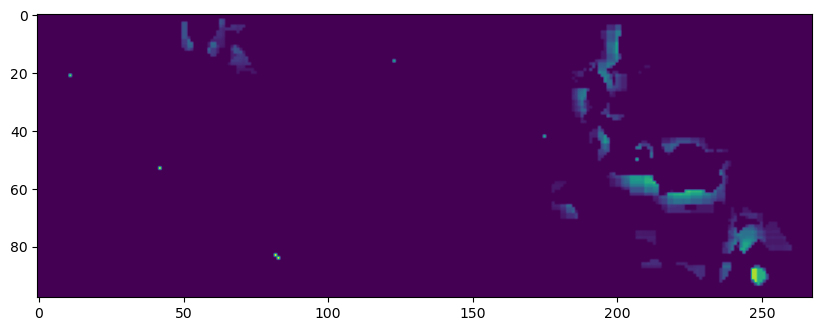

Cluster 7 Response:


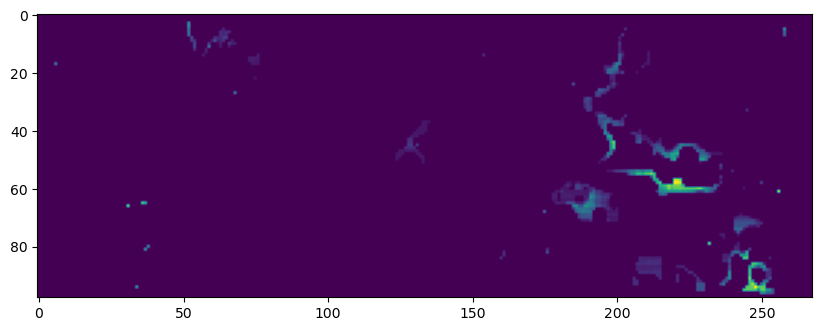

Cluster 8 Response:


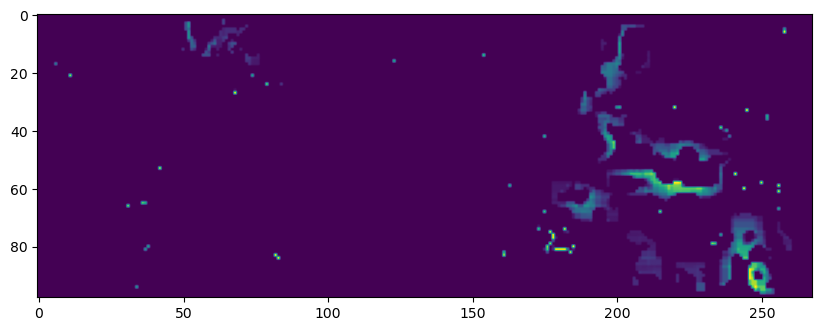

In [30]:
vis_latent_scatter_with_selection('models/umap-dourbes.pkl',
    bins=200,
    min_cluster_size=50,
    center=(555,460),
    selection_radius=5,
    response_latent_radius=1,
    selection_threshold=None,                 
    mixed_cluster_response=True,
    individual_cluster_response=True
)

In [26]:
from scipy.stats import wasserstein_distance_nd
def compare_selection_dists(model_path,center1=None,center2=None,selection_radius=None,bins=300):
    if '.pt' in model_path:
        model = torch.load(model_path).eval().to(device)    

        x , q = [], []
        c, z = [], []
        x_hat, q_hat = [], []
        for batch_x,batch_q in data_loader:
            batch_x = batch_x.to(device)
            batch_q = batch_q.to(device)
            batch_c, batch_z = model.encode(batch_x,batch_q)
            batch_x_hat,  batch_q_hat = model.reconstruct(batch_x,batch_q)
            x.append(batch_x.detach().cpu())
            q.append(batch_q.detach().cpu())
            z.append(batch_z.detach().cpu())
            x_hat.append(batch_x_hat.detach().cpu())
            q_hat.append(batch_q_hat.detach().cpu())

        x = torch.cat(x,dim=0).detach().cpu().numpy()
        q = torch.cat(q,dim=0).detach().cpu().numpy()
        z = torch.cat(z,dim=0).detach().cpu().numpy()
        x_hat = torch.cat(x_hat,dim=0).detach().cpu().numpy()
        q_hat = torch.cat(q_hat,dim=0).detach().cpu().numpy()

        z = z.reshape(-1,z.shape[-1])
        
    elif 'umap' in model_path:
        path = model_path
        with open(path, 'rb') as f:
            umap_values = pickle.load(f)
        z = umap_values['z']
        z = z.reshape(-1,z.shape[-1])
    else:
        raise NotImplementedException(f'Model Path \'{model_path}\' Not Valid')
    
    
    mask1 = get_batch_indicies_from_img(center1[0],center1[1])
    for i in range(-selection_radius,selection_radius):
        for j in range(-selection_radius,selection_radius):
            mask1 = mask1 | get_batch_indicies_from_img(center1[0]+i,center1[1]+j)
    masked_z_1 = z[mask1.reshape((-1,))]
    
    mask2 = get_batch_indicies_from_img(center2[0],center2[1])
    for i in range(-selection_radius,selection_radius):
        for j in range(-selection_radius,selection_radius):
            mask2 = mask2 | get_batch_indicies_from_img(center2[0]+i,center2[1]+j)
    masked_z_2 = z[mask2.reshape((-1,))]

    
    norm = StandardScaler()
    norm.fit(z)
    z_norm = norm.transform(z)
    z1 = norm.transform(masked_z_1)
    z2 = norm.transform(masked_z_2)

    
    fig, axs = plt.subplots(1,3,figsize=(20,5),sharex=True,sharey=True)
    sns.histplot(x=z1[:,0],y=z1[:,1], bins=bins, cmap="viridis",ax=axs[1])
    sns.histplot(x=z2[:,0],y=z2[:,1], bins=bins, cmap="viridis",ax=axs[2])
    sns.histplot(x=z_norm[:,0],y=z_norm[:,1], bins=bins, cmap="viridis",ax=axs[0])
    for ax in axs:
        ax.set_rasterization_zorder(0)
    
    plt.show()
    

    print(wasserstein_distance_nd(z1,z2))


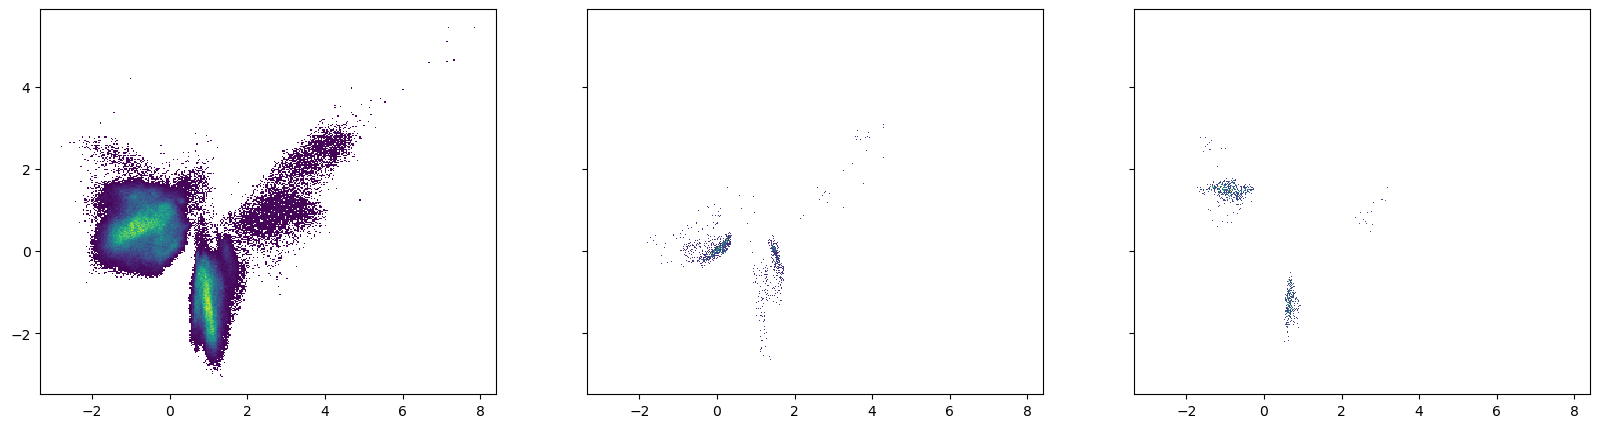

1.4156694755374901


In [27]:
compare_selection_dists(f'models/FusionModel-z-2-c-1-h-256-d-4-r-5.pt',(555,460),(425,470),5)

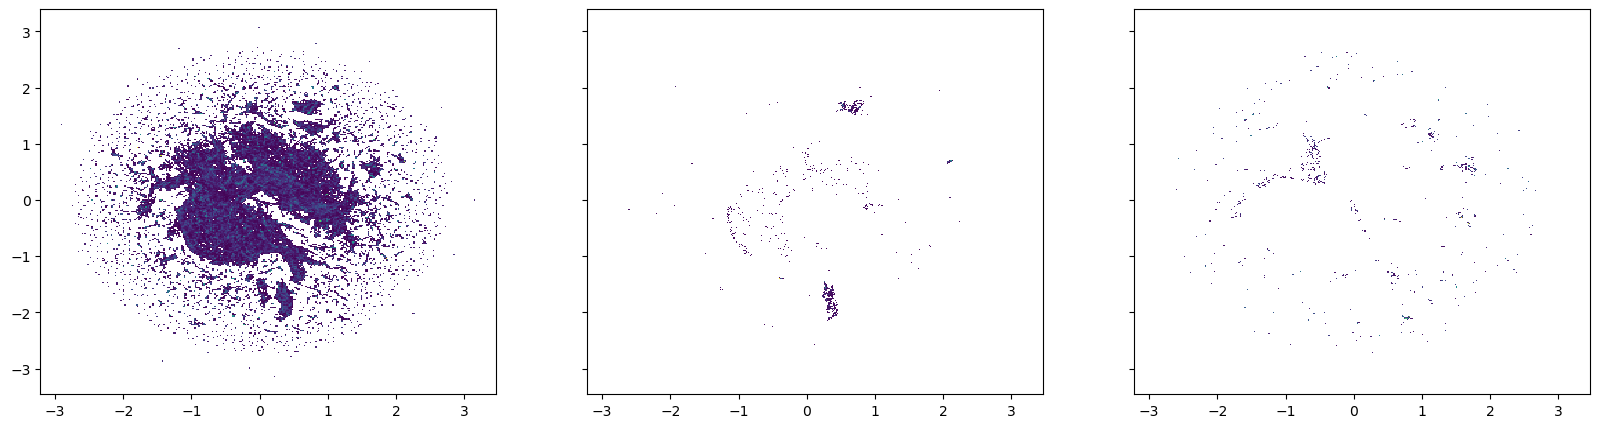

1.0574388030772797


In [28]:
compare_selection_dists(f'models/umap-dourbes.pkl',(555,460),(425,470),5)

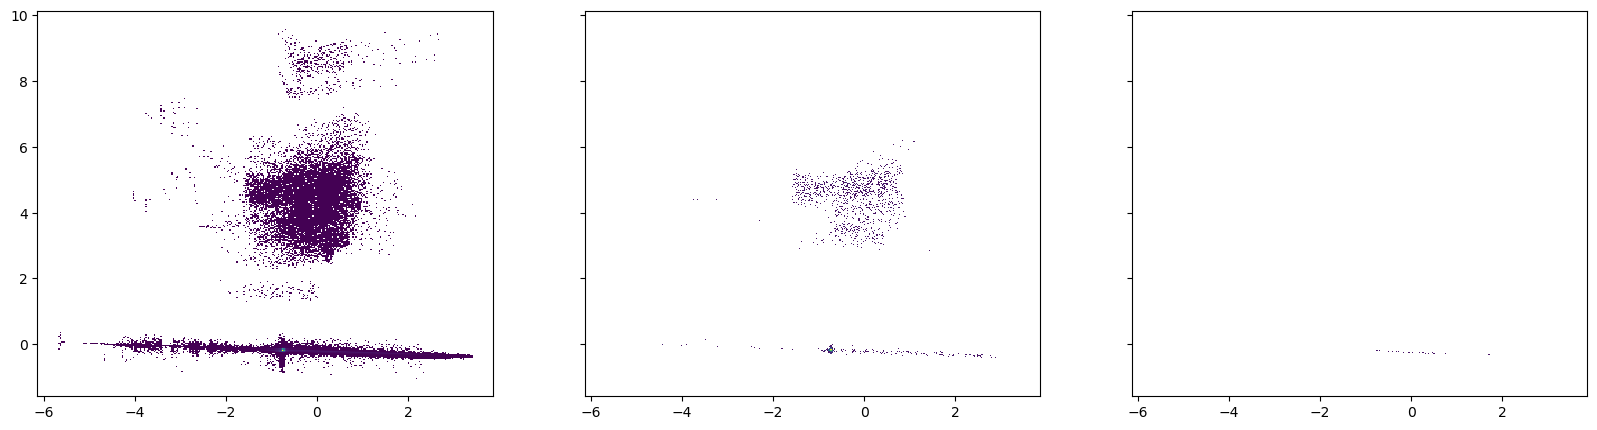

3.80171818811437


In [29]:
compare_selection_dists(f'models/NaiveFusionModel-z-2-c-1-h-64-d-16-r-5.pt',(555,460),(425,470),5)